In this notebook, we quickly explore the dataset, Coporate Message from [data.world](https://data.world/crowdflower/corporate-messaging). This dataset contains posts on social media from different corporates.
For each post, we can classify the content into different categories:
- Information - Objective statements about the company or it's activities
- Dialog - Replies to users, etc
- Action - Messages that ask for votes or ask users to click on links, etc
- Exclude - None of the above categories

In [1]:
import re

import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# ETL

## Extract
Extract phrase usual contains pulling data from different data sources such as:
- Files: `.csv`, `.json`, `.xml`
- Databases: `SQLite`, `mongoDB`, `Postgre`
- API

### Exploratory Data Analysis

First of all, we load the dataset and have a look of the post message and related fields.

In [2]:
df = pd.read_csv("corporate_messaging.csv", encoding="latin-1")
df.head(15)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,category,category:confidence,category_gold,id,screenname,text
0,662822308,False,finalized,3,2/18/15 4:31,Information,1.0000,NaN,4.365280e+17,Barclays,Barclays CEO stresses the importance of regula...
1,662822309,False,finalized,3,2/18/15 13:55,Information,1.0000,NaN,3.860130e+17,Barclays,Barclays announces result of Rights Issue http...
2,662822310,False,finalized,3,2/18/15 8:43,Information,1.0000,NaN,3.795800e+17,Barclays,Barclays publishes its prospectus for its å£5....
3,662822311,False,finalized,3,2/18/15 9:13,Information,1.0000,NaN,3.675300e+17,Barclays,Barclays Group Finance Director Chris Lucas is...
4,662822312,False,finalized,3,2/18/15 6:48,Information,1.0000,NaN,3.603850e+17,Barclays,Barclays announces that Irene McDermott Brown ...
5,662822313,False,finalized,3,2/18/15 8:51,Information,1.0000,NaN,3.476020e+17,Barclays,Barclays response to PRA capital shortfall exe...
6,662822314,False,finalized,3,2/18/15 12:25,Information,1.0000,NaN,3.423160e+17,Barclays,Barclays sponsors #Zamynforum BBC World Servic...
7,662822315,False,finalized,3,2/18/15 9:39,Information,1.0000,NaN,3.273320e+17,Barclays,Barclays has today published its response to T...
8,662822316,False,finalized,3,2/18/15 6:45,Action,0.6747,NaN,2.973020e+17,Barclays,Read statement on #Barclays CEO bonus award 20...
9,662822409,False,finalized,3,2/18/15 12:32,Action,1.0000,NaN,4.568300e+17,barclayswealth,59% of workers are either looking to change jo...


In [3]:
df.shape

(3118, 11)

## Null Value Checking

In [4]:
df.isnull().sum()

_unit_id                  0
_golden                   0
_unit_state               0
_trusted_judgments        0
_last_judgment_at       307
category                  0
category:confidence       0
category_gold          2811
id                        0
screenname                0
text                      0
dtype: int64

## Number of corporates involve

In [5]:
df.screenname.value_counts()

Nestle            914
pfizer_news       580
Citi              440
Merck             319
barclayswealth    301
CitigroupBRK      269
DanoneGroup       246
C_PR               40
Barclays            9
Name: screenname, dtype: int64

## Number of categories and their occurrences

In [6]:
df.category.value_counts()

Information    2129
Action          724
Dialogue        226
Exclude          39
Name: category, dtype: int64

Since we are interested in predicting a given text to its corresponding category, we only need the `text` and `category`. However, we only want the `text` which are not "Exclude" and high confidence level. We can extract the required by applying filters.

In [7]:
new_df = df[(df["category:confidence"] == 1) & (df['category'] != 'Exclude')][['category', 'text']]

In [8]:
for row in new_df.sample(5).iterrows():
    print(f"[{row[1].category}]\n{row[1].text}\n")

[Information]
Barbara Rolls:  What we need to consider is that the water content of food has the biggest impact on energy density.  #NINS2013

[Information]
PFE is partnering w/IFP &amp  UN to sponsor Envision 2013: Stories of the Global Health Challenge #envisionfilm http://t.co/mMXAffWS61

[Information]
Enrobing delicate foods such as ice-cream in chocolate can help to hold their shape. #ChocolateCoveredFacts

[Information]
#Psoriasis is often thought of as a minor condition, but it is associated with an average 4 year reduction in life span #WPD13

[Action]
Today is a day full of jokes but your health is not a laughing matter.Find tips, tools and support to quit smoking at http://t.co/wwGouQrH



## Transform
Transform phrase contains a lot of engineering works such as:
- Cleaning data
- Remove duplicated data and outliers
- Impute data for missing values
- Create dummy variables or One-hot encoding
- Performa Scaling and Standardisation for continuous data

In this project, we do need any transform since we only have two columns: `text` and `category`. For handling text data, we apply transformation in our model pipeline.

## Load
Load Phrase contains loading the transformed data from different sources into a single data storage place such as database. In this project, our project is small and focus on creating a model pipeline. We can directly include the above steps to prepare the data work properly in training phrase.

In [9]:
def load_data():
    df = pd.read_csv("corporate_messaging.csv", encoding='latin-1')
    df = df[(df["category:confidence"] == 1) & (df['category'] != 'Exclude')]
    X = df.text.values
    y = df.category.values
    return X, y

# Training Pipeline
Text data, also known as Natural Language, cannot be directly used in training. We have to apply some transformations such that the model knows what the sentence mean and how they are different/similar to other text data.
Common text preprocessing contains:
1. Normalisation - Convert data into case-insensitive form
2. Tokenisation - Break the sentence into words
3. Remove stop words - Remove common meaningless words
4. Stemming/lemmatisation - Convert word into root form

Our approach
1. We first replace the url into a pattern that it still reflects url existence and remain correlation between texts
2. We tokenise the text sentence using `nltk.tokenize.word_tokenize`
3. We apply lemmatisation using `nltk.stem.WordNetLemmatizer`
4. We clean the tokens by normalising them with `lower()`

In [10]:
def preprocessing(text):
    # regex for finding url in text
    url_regex = "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"

    urls = re.findall(url_regex, text)

    for url in urls:
        text = text.replace(url, "url_placeholder")

    text_tokens = word_tokenize(text)
    lemmatiser = WordNetLemmatizer()

    text_tokens = [lemmatiser.lemmatize(token).lower().strip() for token in text_tokens]

    return text_tokens

Converting the sentences into tokens are not enough to feed data into the model because model cannot directly learn from the text. Therefore, we can use
1. **Bag of words** to make the tokens representative in the collection of documents
2. Counting the term occurrence(t) sometimes does not reflect the important words. Although some terms might appear multiple times in a document, the terms might appear number of times in the rest of the documents. Therefore, we should use **TF-IDF** to find the most distinct words for each document(d)
$$ TF(t, d) = \frac{\#\ t \ in \ D }{\# \ Terms \ in \ d}$$
$$ DF(t) = \# \ t\ in \ d$$
$$ IDF(t) = \log{\frac{N}{DF(t) + 1}}$$
$$ TFIDF(t, d) = TF(t, d) * IDF(t)$$

`Sklearn` provides methods and objects that we do not have to calculate all the above formulas above.
- We can use ``sklearn.feature_extraction.text.CountVectorizer`` for **Bag of words**
- Also, ``sklearn.feature_extraction.text.TfidfTransformer`` for TFIDF

 Traditionally, we are declaring each transformer object and apply `fit_transform` for creating a classifier.

In [11]:
vect = CountVectorizer(tokenizer=preprocessing)
tfidf = TfidfTransformer()
classifier = RandomForestClassifier()

# Train classifier
# X_train_counts = vect.fit_transform(X_train)
# X_train_tfidf = tfidf.fit_transform(X_train_counts)
# clf.fit(X_train_tfidf, y_train)

## Pipeline setup

To improve the readable and maintainability of the model, `Sklearn` also provides a `Pipeline` object such that we can declare the transformer and classifier objects within a variable.

Furthermore, a `Pipeline` can automates repetitive step Chaining all of your steps into one estimator allows user to fit and predict on all steps of your sequence automatically with one call. Therefore, user can focus on implementing higher level changes swiftly and efficiently.

In [12]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=preprocessing)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier()),
])

# Then we cna use fit to train the classifier as usual
# pipeline.fit(X_train)
# pipeline.predict(X_test)

In [13]:
# We can easily see the parameters inside the pipeline using get_params()
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function preprocessing at 0x15049d8b0>)),
  ('tfidf', TfidfTransformer()),
  ('classifier', RandomForestClassifier())],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function preprocessing at 0x15049d8b0>),
 'tfidf': TfidfTransformer(),
 'classifier': RandomForestClassifier(),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.preprocessing(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True,
 'classifier__bootstrap': 

## Last but not least...
When training a model, we want to test out multiple models and various parameters for our task. We can use Grid Search in `sklearn.model_selection.GridSearchCV` to try out all the combination of parameters and return the best parameters of our model.

Below is the random parameters declared to try out with our model.

In [14]:
parameters = {
    "vect__ngram_range": ((1,1), (1,2)),
    "vect__max_features": (None, 100, 200),
    "tfidf__use_idf": (True, False),
    "classifier__n_estimators": [50, 100, 200]
}

## Wrapping it up...
We can declare a method calls `build_model()` to hold our pipeline and grid search parameters for simplicity

In [15]:
def build_model():
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=preprocessing)),
        ('tfidf', TfidfTransformer()),
        ('classifier', RandomForestClassifier()),
    ])

    parameters = {
        "vect__ngram_range": ((1,1), (1,2)),
        "vect__max_df": (0.5, 0.75, 1.0),
        "vect__max_features": (None, 100, 200),
        "tfidf__use_idf": (True, False),
        "classifier__n_estimators": [50, 100, 200]
    }

    cv = GridSearchCV(pipeline, param_grid=parameters)

    return cv

# Training and Prediction

We have arrived the final stage of our ETL and pipeline tutorial. In order to visualise our results and better understand which parameters can have the best accuracy of the test data. We are going to print the **accuracy of the model** and **visualise the confusion matrix** for knowing the distribution of mislabeled classes.

In [16]:
def print_results_comparison(y_test, y_pred):
    true_series = pd.Series(y_test)
    pred_series = pd.Series(y_pred)
    true_pred_series = pd.concat([true_series, pred_series], axis=1)
    return true_pred_series

In [17]:
def plot_confusion_matrix(y_test, y_pred):
    labels=np.unique(y_pred)
    conf_mat = confusion_matrix(y_test, y_pred, labels=labels)

    ax = plt.subplot()
    sns.heatmap(conf_mat, annot=True, cmap="BuPu", fmt="d", ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [18]:
def display_result(model, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)

    print(f"We obtained an accuracy of: {accuracy * 100:.2f}%")
    print(f"The Best parameters: {model.best_params_}")

    plot_confusion_matrix(y_test, y_pred)

We obtained an accuracy of: 94.80%
The Best parameters: {'classifier__n_estimators': 100, 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__ngram_range': (1, 1)}


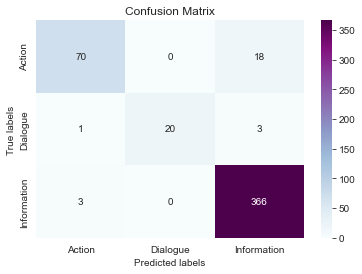

In [19]:
X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = build_model()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

display_result(model, y_test, y_pred)

We obtained a very high accuracy model by trying out different parameters using Grid Search. Feel free to try out more combinations to beat this accuracy!

Below is the side-by-side comparison of `y_test` and `y_pred`

In [20]:
print_results_comparison(y_test, y_pred)

,0,1
0,Action,Action
1,Dialogue,Information
2,Information,Information
3,Information,Information
4,Information,Information
...,...,...
476,Action,Action
477,Action,Information
478,Information,Information
479,Action,Information
